In [1]:
using PyPlot
include("acoustic_solver.jl")

backward_diff_y (generic function with 1 method)

In [6]:
function compute_grad(d_true, a0, b0, Nx, Ny, Nt, dx, dy, dt, source_position, source, receiver_position, source_index)
#     forward
    d0, u0 = acoustic_solver(a0, b0, Nx, Ny, Nt, dx, dy, dt, source_position, source, receiver_position; pml_len=30, pml_alpha=30, source_index=source_index);
#     adjoint
    adj_source = d_true[:,:,source_index] - d0;
    adj_source = adj_source[end:-1:1,:]
    dv, v = acoustic_solver(a0, b0, Nx, Ny, Nt, dx, dy, dt, receiver_position, adj_source, receiver_position; pml_len=30, pml_alpha=30, source_index=0);
#     integral
    uu = similar(u0)
    uu[:,:,2:end-1] = (u0[:,:,1:end-2] - 2 .* u0[:,:,2:end-1] + u0[:,:,3:end]) ./ dt^2
    uu = uu[:,:,end:-1:1]
    g = v .* uu;
    g = sum(g, dims=3) * dt;
    g = g[:,:,1];
    return g
end

# Generate function handle
grad(a, source_index) = compute_grad(d_true, a, b0, Nx, Ny, Nt, dx, dy, dt, source_position, source, receiver_position, source_index);

# Box constraint
function box_func(A, max_v, min_v)
    A[A.>max_v] .= max_v
    A[A.<min_v] .= min_v
    return A
end

# Gradient for all sources
function compute_grad_all(a0, source_num)
    g = zeros(Nx, Ny);
    print("Source: ", source_num, ". Iteration: ")
    for iter = 1:source_num
        g= g + grad(a0, iter);
        print(iter, ", ")
    end
    return g
end

compute_grad_all (generic function with 1 method)

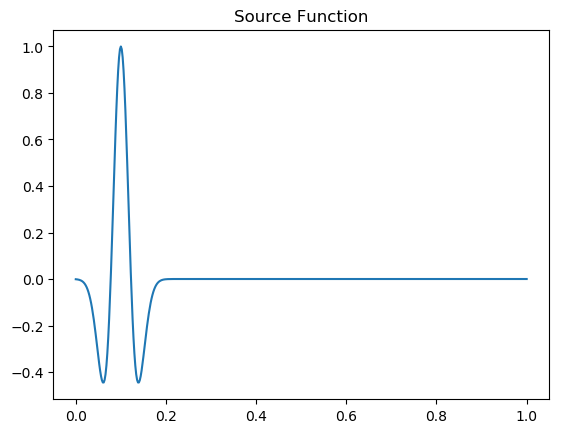

In [2]:
Nx = 51; Ny = 51;
dx = 0.005; dy = dx;

Fs = 500;
dt = 1/Fs;
Nt = 501;
t = range(0, step=dt, length=Nt);

# source_func = sin.(2*pi*20*t);
source_func = source_ricker(10, 0.1, t);
plot(t, source_func); title("Source Function");

In [27]:
source = zeros(Nt,11);
for i = 1:11
    source[:,i] .= source_func;
end
# source[:,1] .=  sin.(2*pi*5*t);

source_position = zeros(Int, 11, 2);
for i = 1:11
    source_position[i,2] = 2
    source_position[i,1] = (i-1)*5+1
#     source_position[i,1] = 50
#     source_position[i,2] = 30
end

# Model 1
receiver_position = zeros(Int,51,2);
for i = 1:51
    receiver_position[i,1] = i
    receiver_position[i,2] = 50;
end
# Model 2
# receiver_position = zeros(Int,1,2);
# for i = 1:1
#     receiver_position[i,2] = 70
#     receiver_position[i,1] = 50
# end

c = 1*ones(Nx, Ny); rho = ones(Nx,Ny);
a0 = 1 ./ (c.^2 .* rho);
b0 = 1 ./ rho;

c[20:30,20:30] .= 1.2;

a = 1 ./ (c.^2 .* rho);
b = 1 ./ rho;
using ImageFiltering
a0 = imfilter(a, Kernel.gaussian(30));
b0 = imfilter(b, Kernel.gaussian(30));

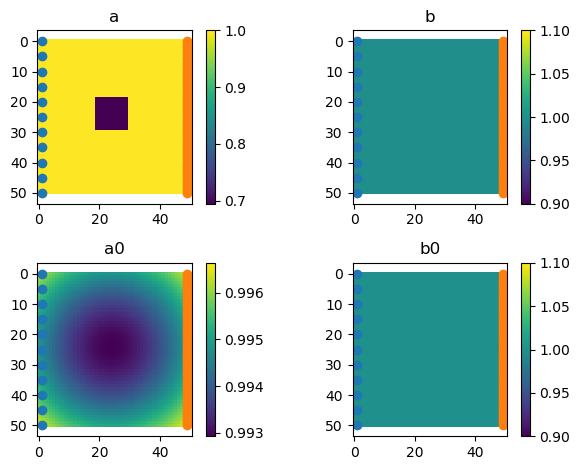

In [28]:
subplot(221)
imshow(a); colorbar(); title("a")
scatter(source_position[:,2].-1, source_position[:,1].-1)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1)

subplot(222)
imshow(b); colorbar(); title("b")
scatter(source_position[:,2].-1, source_position[:,1].-1)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1)

subplot(223)
imshow(a0); colorbar(); title("a0")
scatter(source_position[:,2].-1, source_position[:,1].-1)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1)

subplot(224)
imshow(b0); colorbar(); title("b0")
scatter(source_position[:,2].-1, source_position[:,1].-1)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1)

tight_layout()

## Example

In [5]:
# Compute true solution
@time d_true, u_true = acoustic_solver_all(a, b, Nx, Ny, Nt, dx, dy, dt, source_position, source, receiver_position; pml_len=30, pml_alpha=30);

 14.346659 seconds (8.18 M allocations: 34.477 GiB, 17.23% gc time)


Source: 11. Iteration: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11

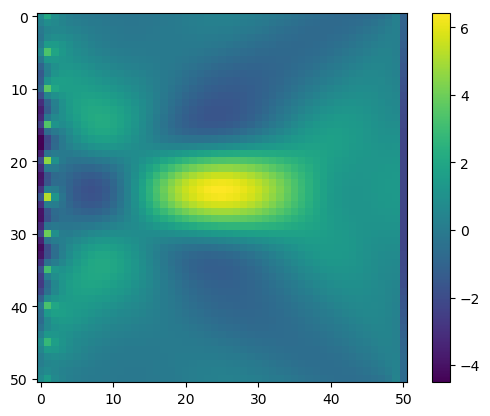

,  22.237698 seconds (5.81 M allocations: 69.379 GiB, 19.78% gc time)


PyObject <matplotlib.colorbar.Colorbar object at 0x7f6133fa5550>

In [7]:
# True gradient
@time gg =  compute_grad_all(a0, 11);

imshow(gg); colorbar()

## SGD

In [29]:
# iterate
step_size = 0.05;
iter_time = 20;
for iter = 1:iter_time
    ind = rand(1:11)
    println("At iteration: ", iter, " random source: ", ind)
#     compute gradient
    gg = grad(a0, ind);
#     update
    a0 = a0 - step_size*gg;
    a0 = box_func(a0, 1, minimum(a))
end

At iteration: 1 random source: 10
At iteration: 2 random source: 8
At iteration: 3 random source: 10
At iteration: 4 random source: 2
At iteration: 5 random source: 4
At iteration: 6 random source: 8
At iteration: 7 random source: 3
At iteration: 8 random source: 9
At iteration: 9 random source: 4
At iteration: 10 random source: 3
At iteration: 11 random source: 7
At iteration: 12 random source: 1
At iteration: 13 random source: 10
At iteration: 14 random source: 5
At iteration: 15 random source: 3
At iteration: 16 random source: 4
At iteration: 17 random source: 10
At iteration: 18 random source: 11
At iteration: 19 random source: 4
At iteration: 20 random source: 7


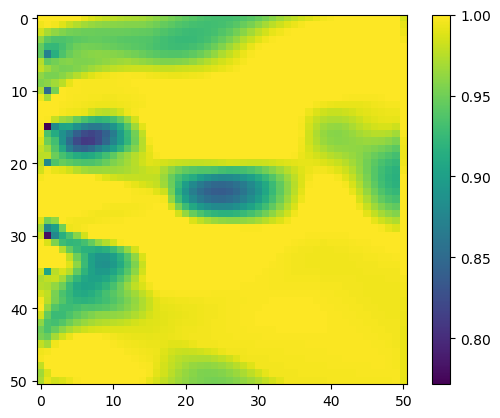

PyObject <matplotlib.colorbar.Colorbar object at 0x7f6138eb7470>

In [30]:
imshow(a0); colorbar()

In [31]:
# iterate
step_size = 0.05;
iter_time = 20;
for iter = 1:iter_time
    ind = rand(1:11)
    println("At iteration: ", iter, " random source: ", ind)
#     compute gradient
    gg = grad(a0, ind);
#     update
    a0 = a0 - step_size*gg;
    a0 = box_func(a0, 1, minimum(a))
end

At iteration: 1 random source: 11
At iteration: 2 random source: 9
At iteration: 3 random source: 7
At iteration: 4 random source: 5
At iteration: 5 random source: 10
At iteration: 6 random source: 10
At iteration: 7 random source: 1
At iteration: 8 random source: 8
At iteration: 9 random source: 7
At iteration: 10 random source: 8
At iteration: 11 random source: 3
At iteration: 12 random source: 3
At iteration: 13 random source: 6
At iteration: 14 random source: 8
At iteration: 15 random source: 11
At iteration: 16 random source: 2
At iteration: 17 random source: 5
At iteration: 18 random source: 6
At iteration: 19 random source: 2
At iteration: 20 random source: 6


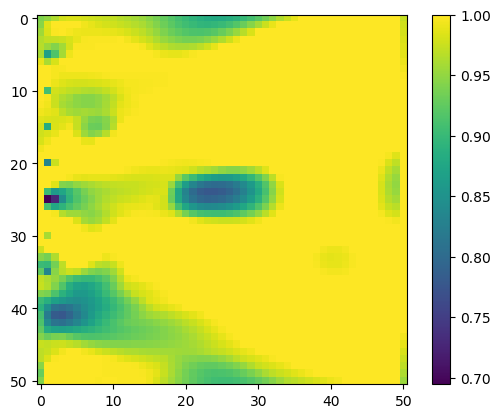

PyObject <matplotlib.colorbar.Colorbar object at 0x7f612c9e90f0>

In [32]:
imshow(a0); colorbar()

In [33]:
# iterate
step_size = 0.05;
iter_time = 20;
for iter = 1:iter_time
    ind = rand(1:11)
    println("At iteration: ", iter, " random source: ", ind)
#     compute gradient
    gg = grad(a0, ind);
#     update
    a0 = a0 - step_size*gg;
    a0 = box_func(a0, 1, minimum(a))
end

At iteration: 1 random source: 9
At iteration: 2 random source: 1
At iteration: 3 random source: 6
At iteration: 4 random source: 5
At iteration: 5 random source: 1
At iteration: 6 random source: 10
At iteration: 7 random source: 4
At iteration: 8 random source: 3
At iteration: 9 random source: 8
At iteration: 10 random source: 10
At iteration: 11 random source: 10
At iteration: 12 random source: 7
At iteration: 13 random source: 9
At iteration: 14 random source: 10
At iteration: 15 random source: 1
At iteration: 16 random source: 8
At iteration: 17 random source: 5
At iteration: 18 random source: 2
At iteration: 19 random source: 8
At iteration: 20 random source: 1


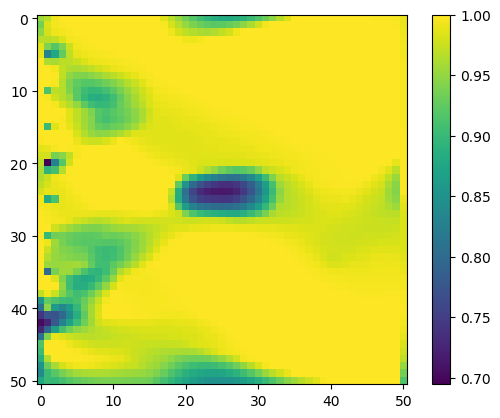

PyObject <matplotlib.colorbar.Colorbar object at 0x7f612c8ff710>

In [34]:
imshow(a0); colorbar()

In [35]:
# iterate
step_size = 0.05;
iter_time = 20;
for iter = 1:iter_time
    ind = rand(1:11)
    println("At iteration: ", iter, " random source: ", ind)
#     compute gradient
    gg = grad(a0, ind);
#     update
    a0 = a0 - step_size*gg;
    a0 = box_func(a0, 1, minimum(a))
end

At iteration: 1 random source: 8
At iteration: 2 random source: 2
At iteration: 3 random source: 4
At iteration: 4 random source: 11
At iteration: 5 random source: 1
At iteration: 6 random source: 8
At iteration: 7 random source: 8
At iteration: 8 random source: 7
At iteration: 9 random source: 10
At iteration: 10 random source: 1
At iteration: 11 random source: 1
At iteration: 12 random source: 7
At iteration: 13 random source: 2
At iteration: 14 random source: 9
At iteration: 15 random source: 1
At iteration: 16 random source: 1
At iteration: 17 random source: 4
At iteration: 18 random source: 2
At iteration: 19 random source: 11
At iteration: 20 random source: 8


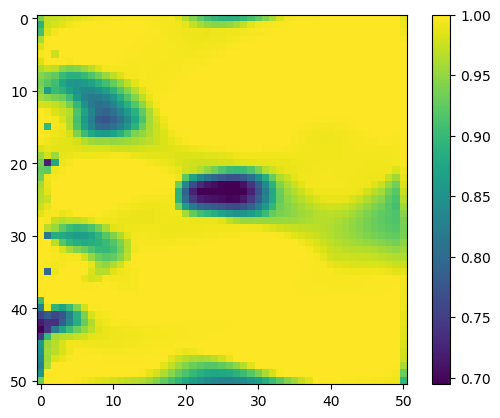

PyObject <matplotlib.colorbar.Colorbar object at 0x7f612c89cd30>

In [36]:
imshow(a0); colorbar()

In [37]:
# iterate
step_size = 0.05;
iter_time = 20;
for iter = 1:iter_time
    ind = rand(1:11)
    println("At iteration: ", iter, " random source: ", ind)
#     compute gradient
    gg = grad(a0, ind);
#     update
    a0 = a0 - step_size*gg;
    a0 = box_func(a0, 1, minimum(a))
end

At iteration: 1 random source: 8
At iteration: 2 random source: 7
At iteration: 3 random source: 10
At iteration: 4 random source: 5
At iteration: 5 random source: 10
At iteration: 6 random source: 7
At iteration: 7 random source: 4
At iteration: 8 random source: 1
At iteration: 9 random source: 6
At iteration: 10 random source: 9
At iteration: 11 random source: 2
At iteration: 12 random source: 5
At iteration: 13 random source: 9
At iteration: 14 random source: 10
At iteration: 15 random source: 7
At iteration: 16 random source: 11
At iteration: 17 random source: 4
At iteration: 18 random source: 8
At iteration: 19 random source: 9
At iteration: 20 random source: 8


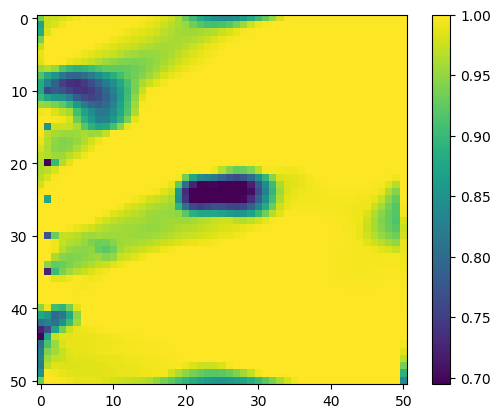

PyObject <matplotlib.colorbar.Colorbar object at 0x7f612c7be390>

In [38]:
imshow(a0); colorbar()

In [39]:
# iterate
step_size = 0.05;
iter_time = 20;
for iter = 1:iter_time
    ind = rand(1:11)
    println("At iteration: ", iter, " random source: ", ind)
#     compute gradient
    gg = grad(a0, ind);
#     update
    a0 = a0 - step_size*gg;
    a0 = box_func(a0, 1, minimum(a))
end

At iteration: 1 random source: 11
At iteration: 2 random source: 10
At iteration: 3 random source: 2
At iteration: 4 random source: 2
At iteration: 5 random source: 10
At iteration: 6 random source: 8
At iteration: 7 random source: 2
At iteration: 8 random source: 6
At iteration: 9 random source: 7
At iteration: 10 random source: 8
At iteration: 11 random source: 2
At iteration: 12 random source: 8
At iteration: 13 random source: 11
At iteration: 14 random source: 8
At iteration: 15 random source: 5
At iteration: 16 random source: 4
At iteration: 17 random source: 6
At iteration: 18 random source: 7
At iteration: 19 random source: 9
At iteration: 20 random source: 7


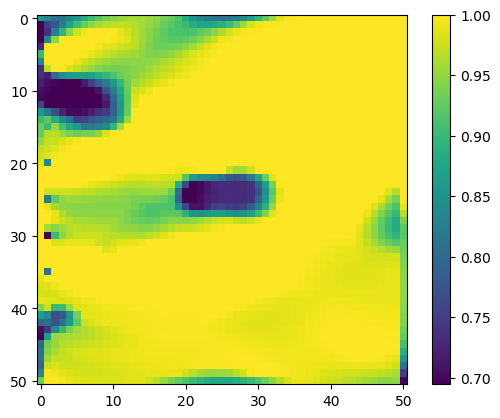

PyObject <matplotlib.colorbar.Colorbar object at 0x7f612c7559b0>

In [40]:
imshow(a0); colorbar()

In [41]:
# iterate
step_size = 0.05;
iter_time = 20;
for iter = 1:iter_time
    ind = rand(1:11)
    println("At iteration: ", iter, " random source: ", ind)
#     compute gradient
    gg = grad(a0, ind);
#     update
    a0 = a0 - step_size*gg;
    a0 = box_func(a0, 1, minimum(a))
end

At iteration: 1 random source: 4
At iteration: 2 random source: 7
At iteration: 3 random source: 8
At iteration: 4 random source: 8
At iteration: 5 random source: 1
At iteration: 6 random source: 3
At iteration: 7 random source: 9
At iteration: 8 random source: 2
At iteration: 9 random source: 5
At iteration: 10 random source: 4
At iteration: 11 random source: 6
At iteration: 12 random source: 8
At iteration: 13 random source: 11
At iteration: 14 random source: 3
At iteration: 15 random source: 9
At iteration: 16 random source: 8
At iteration: 17 random source: 5
At iteration: 18 random source: 8
At iteration: 19 random source: 11
At iteration: 20 random source: 4


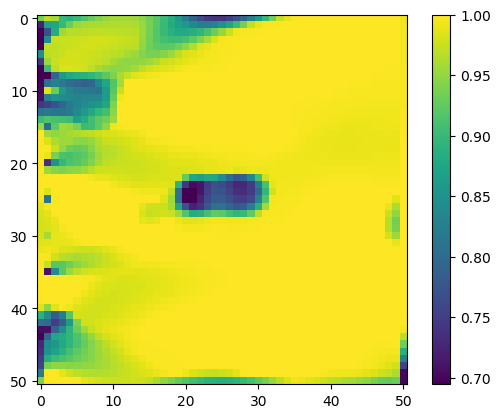

PyObject <matplotlib.colorbar.Colorbar object at 0x7f612c671fd0>

In [42]:
imshow(a0); colorbar()

In [43]:
# iterate
step_size = 0.05;
iter_time = 20;
for iter = 1:iter_time
    ind = rand(1:11)
    println("At iteration: ", iter, " random source: ", ind)
#     compute gradient
    gg = grad(a0, ind);
#     update
    a0 = a0 - step_size*gg;
    a0 = box_func(a0, 1, minimum(a))
end

At iteration: 1 random source: 1
At iteration: 2 random source: 4
At iteration: 3 random source: 10
At iteration: 4 random source: 10
At iteration: 5 random source: 2
At iteration: 6 random source: 3
At iteration: 7 random source: 1
At iteration: 8 random source: 8
At iteration: 9 random source: 3
At iteration: 10 random source: 3
At iteration: 11 random source: 8
At iteration: 12 random source: 1
At iteration: 13 random source: 2
At iteration: 14 random source: 11
At iteration: 15 random source: 1
At iteration: 16 random source: 11
At iteration: 17 random source: 3
At iteration: 18 random source: 6
At iteration: 19 random source: 2
At iteration: 20 random source: 6


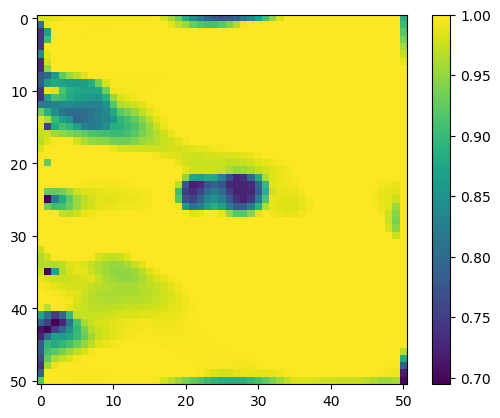

PyObject <matplotlib.colorbar.Colorbar object at 0x7f61340d1748>

In [44]:
imshow(a0); colorbar()

In [45]:
# iterate
step_size = 0.05;
iter_time = 20;
for iter = 1:iter_time
    ind = rand(1:11)
    println("At iteration: ", iter, " random source: ", ind)
#     compute gradient
    gg = grad(a0, ind);
#     update
    a0 = a0 - step_size*gg;
    a0 = box_func(a0, 1, minimum(a))
end

At iteration: 1 random source: 2
At iteration: 2 random source: 7
At iteration: 3 random source: 9
At iteration: 4 random source: 10
At iteration: 5 random source: 9
At iteration: 6 random source: 5
At iteration: 7 random source: 4
At iteration: 8 random source: 11
At iteration: 9 random source: 5
At iteration: 10 random source: 10
At iteration: 11 random source: 10
At iteration: 12 random source: 8
At iteration: 13 random source: 7
At iteration: 14 random source: 11
At iteration: 15 random source: 5
At iteration: 16 random source: 4
At iteration: 17 random source: 8
At iteration: 18 random source: 2
At iteration: 19 random source: 8
At iteration: 20 random source: 4


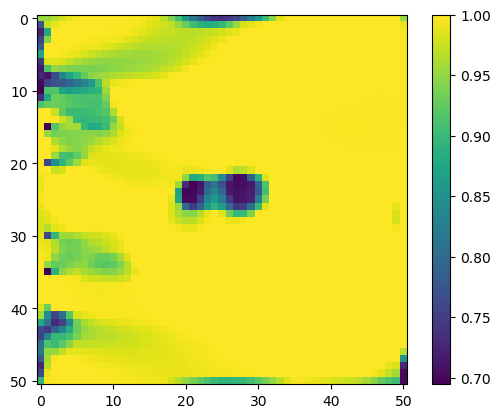

PyObject <matplotlib.colorbar.Colorbar object at 0x7f6140096b00>

In [46]:
imshow(a0); colorbar()